In this notebook, we propose a demonstration of our reimplementation of Stereoscope in the new scvi-tools codebase. We apply our implementation as well as the original code on 10x Visium data from the hippocampus of a mouse brain. 

# Install scvi-tools

In [1]:
import sys

#if True, will install via pypi, else will install from source
stable = False
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@romain/stereoscope_API#egg=scvi-tools[tutorials]

     |████████████████████████████████| 61kB 9.0MB/s 
ERROR: nbclient 0.5.1 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 122kB 17.4MB/s 
     |████████████████████████████████| 686kB 27.9MB/s 
     |████████████████████████████████| 194kB 58.9MB/s 
     |████████████████████████████████| 245kB 56.6MB/s 
     |████████████████████████████████| 2.4MB 59.0MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 3.2MB 53.9MB/s 
     |████████████████████████████████| 10.2MB 48.8MB/s 
     |████████████████████████████████| 8.7MB 58.7MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 645kB 52.5MB/s 
     |████████████████████████████████| 829kB 57.3MB/s 
     |██████████████████████

# Get the single-cell data

In [2]:
!wget https://github.com/YosefLab/scVI-data/blob/master/scRefSubsampled1000_hippocampus_compressed.h5ad?raw=true -O scRef.h5ad

--2021-01-22 22:17:19--  https://github.com/YosefLab/scVI-data/blob/master/scRefSubsampled1000_hippocampus_compressed.h5ad?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/YosefLab/scVI-data/raw/master/scRefSubsampled1000_hippocampus_compressed.h5ad [following]
--2021-01-22 22:17:19--  https://github.com/YosefLab/scVI-data/raw/master/scRefSubsampled1000_hippocampus_compressed.h5ad
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/YosefLab/scVI-data/master/scRefSubsampled1000_hippocampus_compressed.h5ad [following]
--2021-01-22 22:17:19--  https://raw.githubusercontent.com/YosefLab/scVI-data/master/scRefSubsampled1000_hippocampus_compressed.h5ad
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133,

# Import libraries

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Read Spatial transcriptomics data

In [4]:
st_adata = sc.datasets.visium_sge(sample_id="V1_Adult_Mouse_Brain")
st_adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


... storing 'feature_types' as categorical
... storing 'genome' as categorical


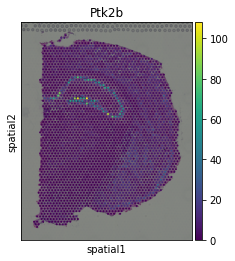

In [5]:
sc.pl.spatial(st_adata, img_key="hires", color=["Ptk2b"])

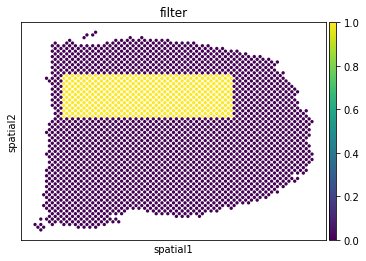

In [6]:
# Take a slice and focus on the hippocampus
sl_adata = st_adata[st_adata.obs["array_row"] > 15]
sl_adata = sl_adata[sl_adata.obs["array_row"] < 32]
sl_adata = sl_adata[sl_adata.obs["array_col"] > 20]
sl_adata = sl_adata[sl_adata.obs["array_col"] < 80]

st_adata.obs["filter"] = [x in sl_adata.obs.index for x in st_adata.obs.index]
sc.pl.embedding(st_adata, basis="spatial", color="filter")

Marker genes
+ CA1: Fibcd1
+ CA3: Npy2r
+ Dentate: Prox1
+ Oligo: Plp1
+ Astrocytes: Aldoc

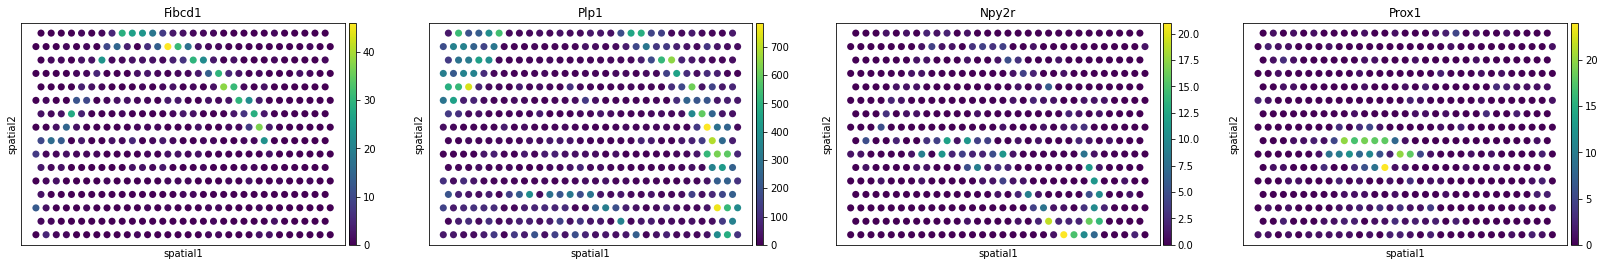

In [7]:
sc.pl.embedding(sl_adata, basis="spatial", color=["Fibcd1", "Plp1", "Npy2r", "Prox1"], size=200)

# Read single-cell RNA Sequencing data

In [8]:
sc_adata = sc.read_h5ad("scRef.h5ad")
sc_adata.obs["liger_ident_coarse"].value_counts()

Polydendrocyte           1000
Oligodendrocyte          1000
CA1                      1000
CA3                      1000
Denate                   1000
Endothelial_Stalk        1000
Entorihinal              1000
Interneuron              1000
Microglia_Macrophages    1000
Mural                    1000
Neuron.Slc17a6           1000
Astrocyte                1000
Neurogenesis              988
Ependymal                 715
Endothelial_Tip           676
Cajal_Retzius             672
Choroid                    44
Name: liger_ident_coarse, dtype: int64

In [9]:
# preprocessing
sc.pp.filter_genes(sc_adata, min_counts=10)
sc_adata.layers["counts"] = sc_adata.X.copy()
# normalization for selection of highly variable genes (not for the deconvolution)
sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata
sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
sl_adata = sl_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [10]:
# visualize for fun
sc.tl.pca(sc_adata, svd_solver='arpack')
sc.pp.neighbors(sc_adata, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(sc_adata)

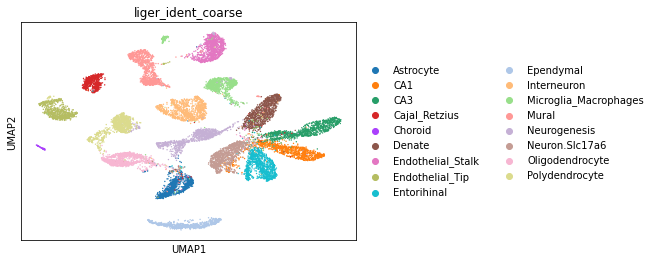

In [11]:
sc.pl.umap(sc_adata, color=['liger_ident_coarse'])

In [12]:
# restore counts for CLI Stereoscope 
sc_adata.X = sc_adata.layers["counts"].copy()

# Learn RNA model (on scRNA-seq data)

In [13]:
import scvi
from scvi.external.stereoscope import RNAStereoscope, SpatialStereoscope

In [14]:
scvi.data.setup_anndata(sc_adata, layer="counts", labels_key="liger_ident_coarse")

INFO     No batch_key inputted, assuming all cells are same batch               
INFO     Using labels from adata.obs["liger_ident_coarse"]                      
INFO     Using data from adata.layers["counts"]                                 
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 15095 cells, 1913    
         vars, 1 batches, 17 labels, and 0 proteins. Also registered 0 extra    
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)


Epoch 100/100: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s, loss=464, v_num=1]


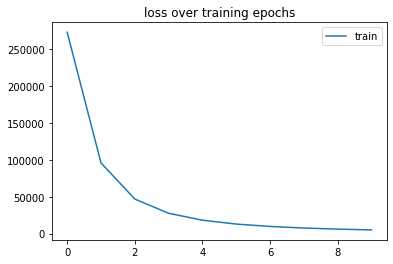

In [15]:
train = True
if train:
  sc_model = RNAStereoscope(sc_adata)
  # here we use "weight_decay=0" to reproduce Stereoscope, but we advise to use the default parameter for all other applications 
  sc_model.train(max_epochs=100, vae_task_kwargs={"weight_decay":0})
  plt.plot(sc_model.history["elbo_train"][:10], label="train")
  plt.title("loss over training epochs")
  plt.legend()
  plt.show()
  sc_model.save("scmodel", overwrite=True)
else:
  sc_model = RNAStereoscope.load("scmodel", sc_adata)
  print("Loaded RNA model from file!")

small detour to get the gene by cell type matrix for the figure

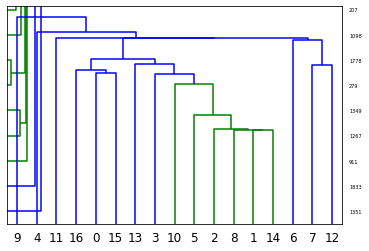

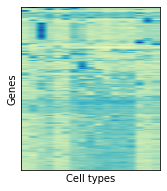

In [16]:
params = sc_model.model.get_params()

import scipy.cluster.hierarchy as sch
Y = sch.linkage(params[0], method='centroid')
Z1 = sch.dendrogram(Y, orientation='left')
X = sch.linkage(params[0].T, method='single')
Z2 = sch.dendrogram(X)

# .matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
plt.figure(figsize=(3, 3))
plt.imshow(params[0][Z1['leaves']][:, Z2['leaves']][:200], aspect=0.1, cmap="YlGnBu")
plt.gca().axes.xaxis.set_ticks([])
plt.gca().axes.yaxis.set_ticks([])
plt.xlabel("Cell types")
plt.ylabel("Genes")
plt.savefig("dict_gene_exp.pdf")
plt.show()

We can check that marker genes have high value of the parameters in the single-cell model. For example, a CA1 marker. Check that the parameter of the marker gene is larger for the CA1 cell type!

In [17]:
list(zip(sc_adata.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"], params[0][np.where(sc_adata.var_names == "Fibcd1")[0][0],]))

[('Astrocyte', -4.974065),
 ('CA1', -0.43588135),
 ('CA3', -4.8345585),
 ('Cajal_Retzius', -3.5441642),
 ('Choroid', -4.848072),
 ('Denate', -3.7801902),
 ('Endothelial_Stalk', -5.570034),
 ('Endothelial_Tip', -4.852148),
 ('Entorihinal', -4.3788195),
 ('Ependymal', -5.578084),
 ('Interneuron', -4.6212792),
 ('Microglia_Macrophages', -4.341202),
 ('Mural', -4.9553337),
 ('Neurogenesis', -5.0046496),
 ('Neuron.Slc17a6', -4.3958817),
 ('Oligodendrocyte', -5.2228327),
 ('Polydendrocyte', -4.0288596)]

In [18]:
list(zip(sc_adata.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"], params[0][np.where(sc_adata.var_names == "Fibcd1")[0][0],]))

[('Astrocyte', -4.974065),
 ('CA1', -0.43588135),
 ('CA3', -4.8345585),
 ('Cajal_Retzius', -3.5441642),
 ('Choroid', -4.848072),
 ('Denate', -3.7801902),
 ('Endothelial_Stalk', -5.570034),
 ('Endothelial_Tip', -4.852148),
 ('Entorihinal', -4.3788195),
 ('Ependymal', -5.578084),
 ('Interneuron', -4.6212792),
 ('Microglia_Macrophages', -4.341202),
 ('Mural', -4.9553337),
 ('Neurogenesis', -5.0046496),
 ('Neuron.Slc17a6', -4.3958817),
 ('Oligodendrocyte', -5.2228327),
 ('Polydendrocyte', -4.0288596)]

# Infer proportion for spatial data



In [19]:
sl_adata.layers["counts"] = sl_adata.X.copy()
scvi.data.setup_anndata(sl_adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch               
INFO     No label_key inputted, assuming all cells have same label              
INFO     Using data from adata.layers["counts"]                                 
INFO     Computing library size prior per batch                                 
INFO     Successfully registered anndata object containing 472 cells, 1913 vars,
         1 batches, 1 labels, and 0 proteins. Also registered 0 extra           
         categorical covariates and 0 extra continuous covariates.              
INFO     Please do not further modify adata until model is trained.             


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 7/5000:   0%|          | 6/5000 [00:00<02:25, 34.36it/s, loss=1.62e+06, v_num=1]

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)


Epoch 5000/5000: 100%|██████████| 5000/5000 [02:05<00:00, 39.71it/s, loss=2.51e+05, v_num=1]


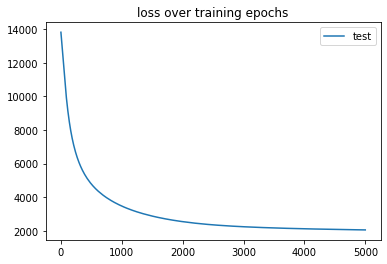

In [20]:
train=True
if train:
  # here we use "minibatch" to reproduce Stereoscope, but we advise to use the default parameter for all other applications 
  # here we use "weight_decay=0" to reproduce Stereoscope, but we advise to use the default parameter for all other applications 
  spatial_model = SpatialStereoscope.from_rna_model(sl_adata, sc_model, prior_weight="minibatch")
  spatial_model.train(max_epochs=5000, vae_task_kwargs={"weight_decay":0})
  plt.plot(spatial_model.history["elbo_train"], label="test")
  plt.title("loss over training epochs")
  plt.legend()
  plt.show()
  spatial_model.save("stmodel", overwrite=True)
else:
  spatial_model = SpatialStereoscope.load("stmodel", sl_adata)
  print("Loaded Spatial model from file!")

In [22]:
sl_adata.obsm["deconvolution"] = spatial_model.get_proportions()

In [23]:
for ct in sl_adata.obsm["deconvolution"].columns:
    sl_adata.obs[ct] = sl_adata.obsm["deconvolution"][ct]

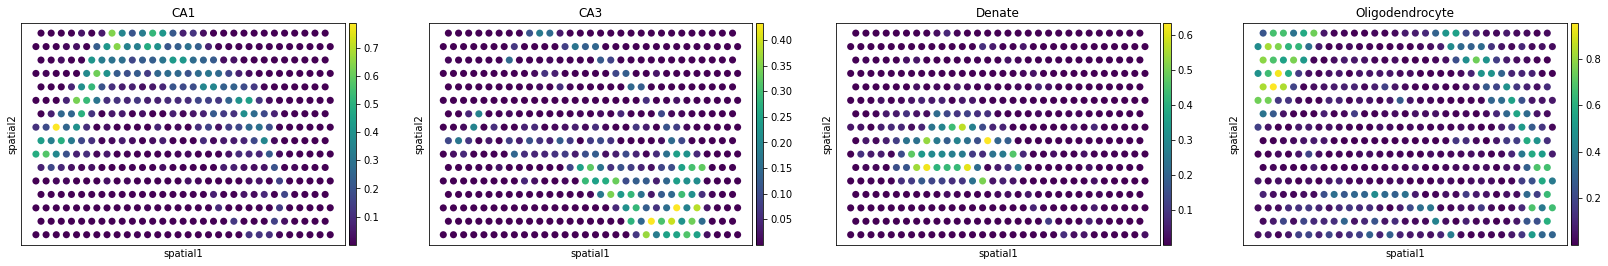

In [24]:
sc.pl.embedding(sl_adata, basis="spatial", color=["CA1", "CA3", "Denate", "Oligodendrocyte"], size=200)

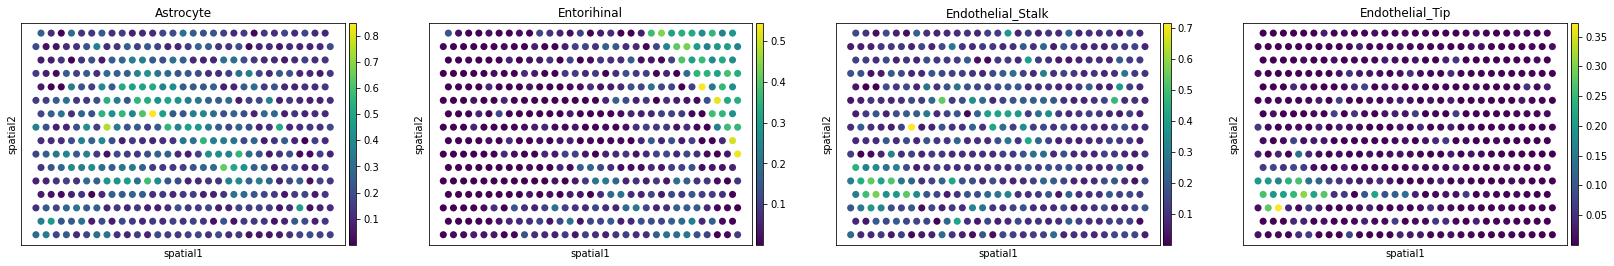

In [ ]:
sc.pl.embedding(sl_adata, basis="spatial", color=["Astrocyte", "Entorihinal", "Endothelial_Stalk", "Endothelial_Tip"], size=200)

In [ ]:
sl_adata.obsm["deconvolution"].columns

Index(['Astrocyte', 'CA1', 'CA3', 'Cajal_Retzius', 'Choroid', 'Denate',
       'Endothelial_Stalk', 'Endothelial_Tip', 'Entorihinal', 'Ependymal',
       'Interneuron', 'Microglia_Macrophages', 'Mural', 'Neurogenesis',
       'Neuron.Slc17a6', 'Oligodendrocyte', 'Polydendrocyte'],
      dtype='object')

small detour to get a nice plot for the paper

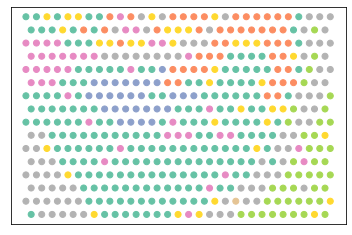

In [ ]:
plt.scatter(sl_adata.obsm["spatial"][:, 0],  sl_adata.obsm["spatial"][:, 1], c=sl_adata.obsm["deconvolution"].values.argmax(1), cmap="Set2")
# cmap="YlGnBu")
plt.gca().axes.xaxis.set_ticks([])
plt.gca().axes.yaxis.set_ticks([])
# plt.xlabel("Cell types")
# plt.ylabel("Genes")
plt.savefig("cell_type_location.pdf")


Save files for input to original Stereoscope

In [ ]:
sl_adata.write_h5ad("sl_adata.h5ad")
sc_adata.write_h5ad("sc_adata.h5ad")

# Install Stereoscope from source

In [ ]:
# must use my own fork because of circular dependencies in the original codebase that didn't work out for Colab (unknown reason; only two import lines deleted)
!git clone https://github.com/romain-lopez/stereoscope 

Cloning into 'stereoscope'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 574 (delta 139), reused 172 (delta 63), pack-reused 308
Receiving objects: 100% (574/574), 57.61 MiB | 44.93 MiB/s, done.
Resolving deltas: 100% (292/292), done.


In [ ]:
%%capture
!cd stereoscope; ./setup.py install

In [ ]:
!python -c "import stsc; print(stsc.__version__)"
!stereoscope test

stereoscope : 0.2.0


# Run Stereoscope & read results

In [ ]:
!stereoscope run --sc_cnt sc_adata.h5ad --label_colname liger_ident_coarse --st_cnt sl_adata.h5ad \
-sce 100  -o stereo-out -n 2000 -ste 5000 --gpu -stb 128 -scb 128

[2021-01-11 18:58:20,236 - stsc - INFO ] >> Using device cuda
[2021-01-11 18:58:20,236 - stsc - INFO ] >> fitting sc data | count file : sc_adata.h5ad | labels file : None
[2021-01-11 18:58:20,752 - stsc - INFO ] >> SC data GENES : 1913  SC data CELLS : 15095  SC data TYPES : 17 


Epoch : 100/100 | Loss : 6.817701E+06 | [ =================== ] 

[2021-01-11 18:59:24,098 - stsc - INFO ] >> fit st data section(s) : ['sl_adata.h5ad']
[2021-01-11 18:59:24,167 - stsc - INFO ] >> ST data GENES : 1913  ST data SPOTS : 472 


Epoch : 5000/5000 | Loss : 9.894005E+05 | [ =================== ] 

[2021-01-11 19:00:51,692 - stsc - INFO ] >> saving proportions for section sl_adata to stereo-out/sl_adata/W.2021-01-11185820.229649.tsv


In [ ]:
import os
path = "stereo-out/sl_adata/"
stereo_out = pd.read_csv(path+os.listdir(path)[0],  sep="\t", index_col=0)

In [ ]:
stereo_out.index = sl_adata.obs.index.copy()
sl_adata.obsm["stereo_deconvolution"] = stereo_out

In [ ]:
def prettify_axis(ax):
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

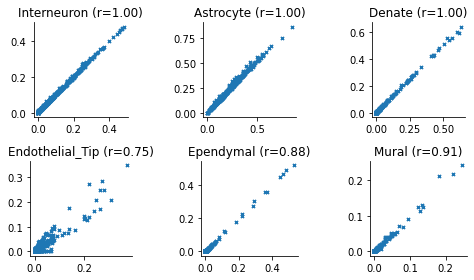

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4))
indices = [11, 10,  4]
for i, ct in enumerate(["Interneuron", "Astrocyte", "Denate"]):
  prettify_axis(axs[0, i])
  axs[0, i].scatter(sl_adata.obsm["deconvolution"][ct], stereo_out[ct], marker="x", s=10)
  axs[0, i].set_title(ct + " (r="+"{:0.2f}".format(scores_spearman[indices[i]])+")")
  axs[0, i].set_aspect('equal', adjustable='box')
  # axs[i].plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), c="black")
indices = [7,  9, 12]
for i, ct in enumerate(["Endothelial_Tip", "Ependymal", "Mural"]):
  prettify_axis(axs[1, i])
  axs[1, i].scatter(sl_adata.obsm["deconvolution"][ct], stereo_out[ct], marker="x", s=10)
  axs[1, i].set_title(ct + " (r="+"{:0.2f}".format(scores_spearman[indices[i]])+")")
  axs[1, i].set_aspect('equal', adjustable='box')
  # axs[i].plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), c="black")
plt.tight_layout()
plt.savefig("repro.pdf")
plt.show()

In [ ]:
from scipy.stats import spearmanr, pearsonr
scores_spearman = []
scores_pearson = []

for i, ct in enumerate(sl_adata.obsm["deconvolution"].columns):
    scores_spearman.append(spearmanr(sl_adata.obsm["deconvolution"][ct], stereo_out[ct]).correlation)
    scores_pearson.append(pearsonr(sl_adata.obsm["deconvolution"][ct], stereo_out[ct])[0])

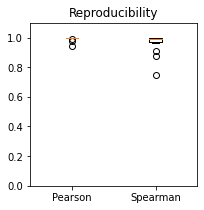

In [ ]:
plt.figure(figsize=(3, 3))
plt.boxplot([scores_pearson, scores_spearman])
plt.xticks([1, 2], ['Pearson', 'Spearman'])
plt.ylim((0, 1.1))
plt.title("Reproducibility")
plt.savefig("repro.pdf")
plt.show()

In [ ]:
np.argsort(scores_spearman)

array([ 7,  9, 12, 13,  5,  2, 16,  6,  1,  3, 14,  0, 15,  8, 11, 10,  4])

In [ ]:
sl_adata.obsm["deconvolution"].columns[12]

'Mural'

In [ ]:
scores_spearman

[0.9955346454408742,
 0.9889706461338035,
 0.975399980691099,
 0.9907579747929829,
 0.9996013830285714,
 0.9691261854946333,
 0.9836318262728412,
 0.7480787529280033,
 0.9959690957157749,
 0.8782247405452004,
 0.9983942343530002,
 0.9977375947728112,
 0.9101956932021028,
 0.9608523441941718,
 0.9932747508273043,
 0.9957647089434222,
 0.9781873324022762]